<a href="https://colab.research.google.com/github/smohanna/EAEE4000_Rainfall_Intensity/blob/main/B_ERIF_Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brazil Extreme Rainfall Intensity Forecaster (B-ERIF): Recalibrating IFD Curves

**Goal.** Use machine learning (RF, XGBoost, MLP, LSTM, VAE) to:
1. Learn the relationship between daily rainfall, time features, and extremes in Rio Grande do Sul using CHIRPS (2000–2024).
2. Recalibrate observed Intensity–Duration–Frequency (IDF) curves and compare them with the May 2024 flood event.

This notebook uses CHIRPS daily rainfall over Rio Grande do Sul (Brazil) to:
- build a historical database (2000–2024) and isolate the May 2024 flood window;
- train several machine learning models to predict extreme rainfall;
- train a generative VAE on annual rainfall maxima;
- recalibrate IDF curves using the best-performing models.

**Author:** Sarah Mohanna Araújo  
**Course:** EAEEE4000 – Machine Learning for Environmental Engineering – Final Project



**1. Setup & data loading**

1.1 Imports and configuration

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use("seaborn-v0_8")
sns.set()

# Utility function to display results
def evaluate_model(name, model, X_test, y_test, time_taken=0):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return {
        'Model': name,
        'RMSE': rmse,
        'R2 Score': r2,
        'Predictions': y_pred  # Storing predictions for plotting later
    }


1.2 Mount Google Drive & paths

In [6]:
from google.colab import drive
drive.mount('/content/drive')

# Paths
hist_path  = "/content/drive/MyDrive/chuva_RS_chirps_2000_2024.csv"
flood_path = "/content/drive/MyDrive/chuva_RS_chirps_maio2024.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1.3 Load historical CHIRPS and flood window

In [7]:
df_hist  = pd.read_csv(hist_path,  parse_dates=["date"])
df_flood = pd.read_csv(flood_path, parse_dates=['time'])
df_flood = df_flood.rename(columns={'time': 'date'})

print("Historical period:", df_hist["date"].min().date(), "→", df_hist["date"].max().date())
print("Flood window    :", df_flood["date"].min().date(), "→", df_flood["date"].max().date())
print("Hist shape:", df_hist.shape, "Flood shape:", df_flood.shape)


Historical period: 2000-01-01 → 2024-05-31
Flood window    : 2023-01-01 → 2024-05-31
Hist shape: (158677974, 7) Flood shape: (517, 4)


In [8]:
# Standardize columns
df_hist.rename(columns={"rain_mm": "rain_mm"}, inplace=True)
df_flood.rename(columns={"precipitation": "rain_mm"}, inplace=True)
df_hist.rename(columns={"y": "lat", "x": "lon"}, inplace=True)
df_flood.rename(columns={"y": "lat", "x": "lon"}, inplace=True)

print("After rename – HIST:", df_hist.columns.tolist())
print("After rename – FLOOD:", df_flood.columns.tolist())


After rename – HIST: ['date', 'lat', 'lon', 'rain_mm', 'year', 'month', 'day']
After rename – FLOOD: ['date', 'lon', 'lat', 'rain_mm']


1.4 Basic exploratory plots

*   Plot daily mean rainfall over RS vs time
*   Histogram of daily rainfall
*   Map




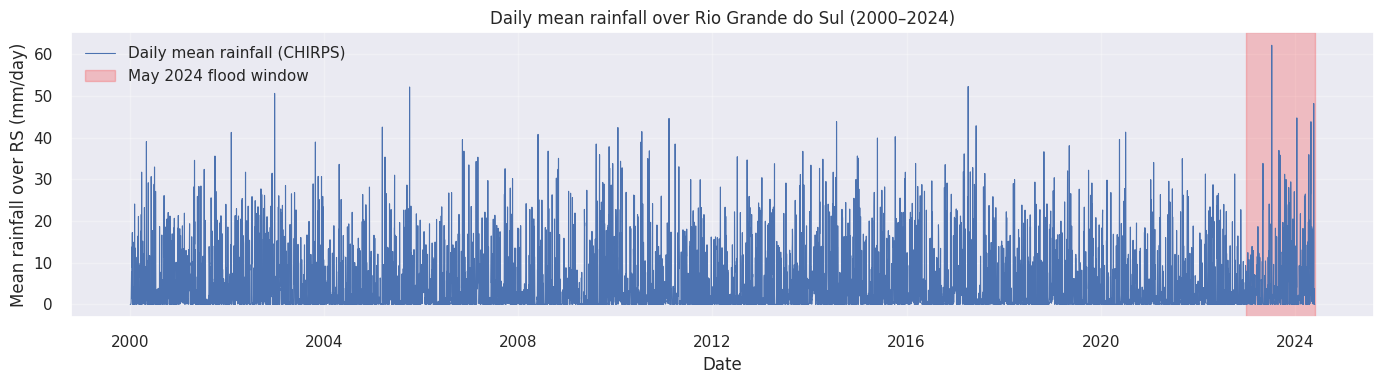

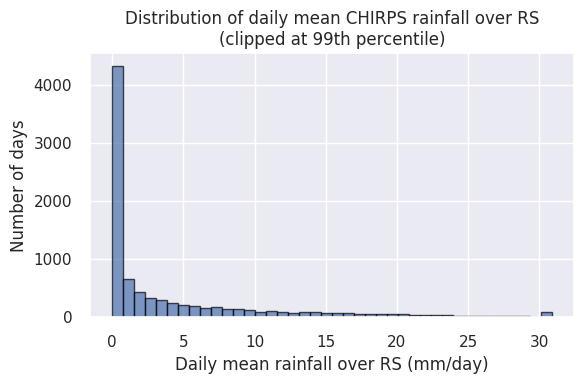

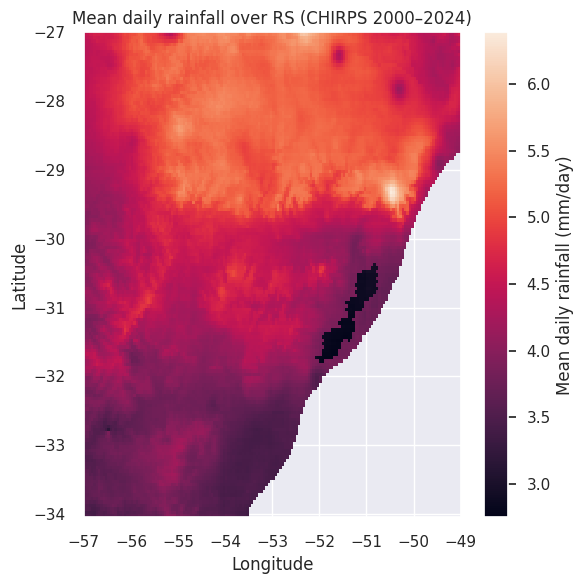

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Helper: detect lon/lat column names
lon_col = "lon" if "lon" in df_hist.columns else "x"
lat_col = "lat" if "lat" in df_hist.columns else "y"

# -------------------------------------------------------------------
# 1) Daily mean rainfall over Rio Grande do Sul (2000–2024)
# -------------------------------------------------------------------
daily_mean = (
    df_hist
    .groupby("date")["rain_mm"]
    .mean()
    .sort_index()
)

flood_start = df_flood["date"].min()
flood_end   = df_flood["date"].max()

plt.figure(figsize=(14, 4))
plt.plot(daily_mean.index, daily_mean.values, linewidth=0.8, label="Daily mean rainfall (CHIRPS)")
plt.axvspan(flood_start, flood_end, color="red", alpha=0.2, label="May 2024 flood window")
plt.xlabel("Date")
plt.ylabel("Mean rainfall over RS (mm/day)")
plt.title("Daily mean rainfall over Rio Grande do Sul (2000–2024)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 2) Histogram of daily rainfall (all grid cells, all days)
# -------------------------------------------------------------------
# 2A) Histogram of daily mean rainfall over RS
daily_mean_rain = (
    df_hist
    .groupby("date")["rain_mm"]
    .mean()
)

plt.figure(figsize=(6, 4))
p99_daily = daily_mean_rain.quantile(0.99)

plt.hist(
    daily_mean_rain.clip(upper=p99_daily),
    bins=40,
    edgecolor="black",
    alpha=0.7
)
plt.xlabel("Daily mean rainfall over RS (mm/day)")
plt.ylabel("Number of days")
plt.title("Distribution of daily mean CHIRPS rainfall over RS\n(clipped at 99th percentile)")
plt.tight_layout()
plt.show()


# -------------------------------------------------------------------
# 3) Map: mean daily rainfall over RS (2000–2024)
# -------------------------------------------------------------------
mean_map = (
    df_hist
    .groupby([lat_col, lon_col])["rain_mm"]
    .mean()
    .reset_index()
)

# Pivot to 2D grid for plotting
grid = mean_map.pivot(index=lat_col, columns=lon_col, values="rain_mm")
lats = grid.index.values
lons = grid.columns.values

plt.figure(figsize=(6, 6))
plt.pcolormesh(lons, lats, grid.values, shading="auto")
plt.colorbar(label="Mean daily rainfall (mm/day)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Mean daily rainfall over RS (CHIRPS 2000–2024)")
plt.tight_layout()
plt.show()


Typical rainy day : 2011-12-16 mean = 1.77 mm
Extreme rainy day : 2024-05-02 mean = 43.84 mm


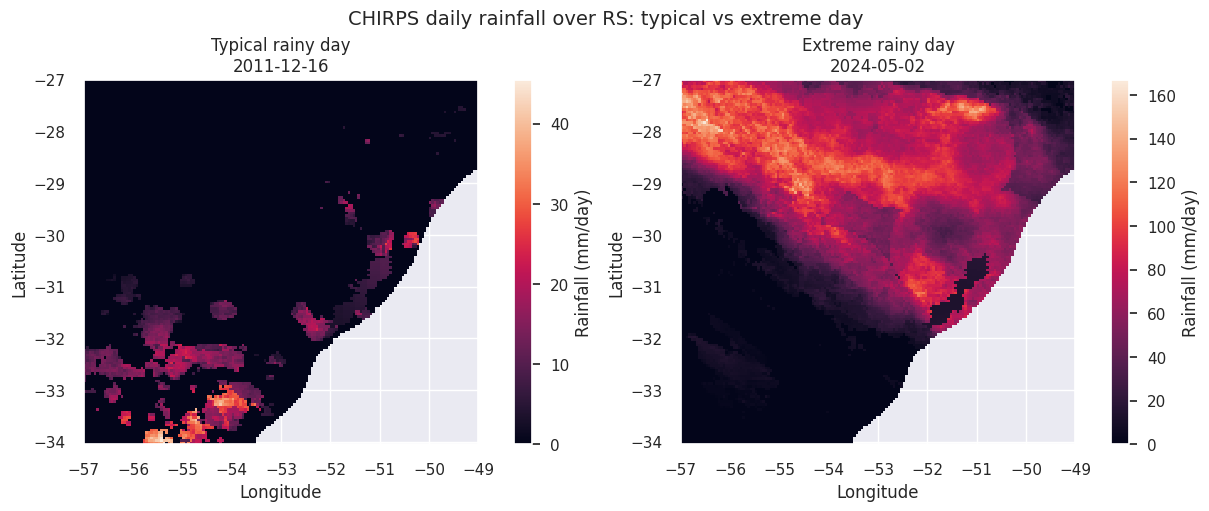

In [10]:
# -----------------------------------------------
# Map comparison: "typical rainy day" vs "extreme day"
# -----------------------------------------------

# 1) Daily mean rainfall over RS
daily_mean = (
    df_hist
    .groupby("date")["rain_mm"]
    .mean()
    .sort_index()
)

# Optional: ignore completely dry days
daily_mean_nonzero = daily_mean[daily_mean > 0]

# Choose a "typical" rainy day ~ median
median_val = daily_mean_nonzero.median()
typical_date = (daily_mean_nonzero - median_val).abs().idxmin()

# Choose an "extreme" day ~ 99th percentile
p99_val = daily_mean_nonzero.quantile(0.99)
extreme_date = pd.Timestamp("2024-05-02")
#extreme_date = (daily_mean_nonzero - p99_val).abs().idxmin()

print("Typical rainy day :", typical_date.date(), "mean =", daily_mean[typical_date].round(2), "mm")
print("Extreme rainy day :", extreme_date.date(), "mean =", daily_mean[extreme_date].round(2), "mm")


# 2) Build maps for those two dates
typical_map = (
    df_hist[df_hist["date"] == typical_date]
    .groupby([lat_col, lon_col])["rain_mm"]
    .mean()
    .reset_index()
)

extreme_map = (
    df_hist[df_hist["date"] == extreme_date]
    .groupby([lat_col, lon_col])["rain_mm"]
    .mean()
    .reset_index()
)

typical_grid = typical_map.pivot(index=lat_col, columns=lon_col, values="rain_mm")
extreme_grid = extreme_map.pivot(index=lat_col, columns=lon_col, values="rain_mm")

lats = typical_grid.index.values
lons = typical_grid.columns.values

# 3) Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Typical day
im1 = axes[0].pcolormesh(lons, lats, typical_grid.values, shading="auto")
axes[0].set_title(f"Typical rainy day\n{typical_date.date()}")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
cb1 = fig.colorbar(im1, ax=axes[0])
cb1.set_label("Rainfall (mm/day)")

# Extreme day
im2 = axes[1].pcolormesh(lons, lats, extreme_grid.values, shading="auto")
axes[1].set_title(f"Extreme rainy day\n{extreme_date.date()}")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
cb2 = fig.colorbar(im2, ax=axes[1])
cb2.set_label("Rainfall (mm/day)")

fig.suptitle("CHIRPS daily rainfall over RS: typical vs extreme day", fontsize=14)
plt.show()


**2. Feature engineering**

2.1 Temporal features

2.2 Aggregations for IFD/ML

*   daily rainfall / rolling sums para durações (1, 3, 6, 12, 24h)
*   maybe monthly totals / annual maxima



In [11]:
for df in [df_hist, df_flood]:
    df["year"]  = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"]   = df["date"].dt.day
    df["doy"]   = df["date"].dt.dayofyear

# Example aggregation: daily mean rain over RS (if you have lat/lon grid)
# You can keep both raw grid and aggregated series
hist_daily = (
    df_hist
    .groupby("date")["rain_mm"]
    .mean()
    .rename("rain_mm_mean_RS")
    .reset_index()
)

flood_daily = (
    df_flood
    .groupby("date")["rain_mm"]
    .mean()
    .rename("rain_mm_mean_RS")
    .reset_index()
)

print("Hist_daily:", hist_daily["rain_mm_mean_RS"].describe())
print("Flood_daily:", flood_daily["rain_mm_mean_RS"].describe())


Hist_daily: count    8918.000000
mean        4.492123
std         7.164613
min         0.000000
25%         0.020608
50%         0.896808
75%         6.107051
max        62.184909
Name: rain_mm_mean_RS, dtype: float64
Flood_daily: count    517.000000
mean       4.704274
std       10.476039
min        0.000000
25%        0.000000
50%        0.000000
75%        3.434895
max       78.737930
Name: rain_mm_mean_RS, dtype: float64


In [12]:
# 2.2 Extra aggregations for IFD / ML
# -----------------------------------

import pandas as pd

# We will use the RS-mean daily series for now
# hist_daily: ['date', 'rain_mm_mean_RS']
# flood_daily: ['date', 'rain_mm_mean_RS']

durations_days = [1, 3, 5, 7]  # rolling windows in days (can adjust)

hist_agg = hist_daily.copy()
flood_agg = flood_daily.copy()

for d in durations_days:
    col_name = f"rain_{d}d_mm"
    hist_agg[col_name] = (
        hist_agg["rain_mm_mean_RS"]
        .rolling(window=d, min_periods=d)
        .sum()
    )
    flood_agg[col_name] = (
        flood_agg["rain_mm_mean_RS"]
        .rolling(window=d, min_periods=d)
        .sum()
    )

hist_agg.head(), flood_agg.head()


(        date  rain_mm_mean_RS  rain_1d_mm  rain_3d_mm  rain_5d_mm  rain_7d_mm
 0 2000-01-01         0.000000    0.000000         NaN         NaN         NaN
 1 2000-01-02         0.000000    0.000000         NaN         NaN         NaN
 2 2000-01-03         0.001387    0.001387    0.001387         NaN         NaN
 3 2000-01-04         0.000000    0.000000    0.001387         NaN         NaN
 4 2000-01-05         0.024208    0.024208    0.025595    0.025595         NaN,
         date  rain_mm_mean_RS  rain_1d_mm  rain_3d_mm  rain_5d_mm  rain_7d_mm
 0 2023-01-01              0.0         0.0         NaN         NaN         NaN
 1 2023-01-02              0.0         0.0         NaN         NaN         NaN
 2 2023-01-03              0.0         0.0         0.0         NaN         NaN
 3 2023-01-04              0.0         0.0         0.0         NaN         NaN
 4 2023-01-05              0.0         0.0         0.0         0.0         NaN)

In [13]:
# Annual maxima per duration (observed IFD baseline)
# --------------------------------------------------

def build_annual_max(df_daily, durations, value_prefix="rain"):
    """
    df_daily: DataFrame with 'date' and rolling-sum columns (e.g. rain_1d_mm, rain_3d_mm, ...)
    durations: list of durations (e.g. [1,3,5,7])
    """
    df = df_daily.copy()
    df["year"] = df["date"].dt.year

    records = []

    for d in durations:
        col = f"{value_prefix}_{d}d_mm"
        tmp = (
            df.groupby("year")[col]
              .max()
              .reset_index()
              .rename(columns={col: "max_rain_mm"})
        )
        tmp["duration_days"] = d
        records.append(tmp)

    annual_max_df = pd.concat(records, ignore_index=True)
    return annual_max_df

idf_obs = build_annual_max(hist_agg, durations_days)

idf_obs.head()


,year,max_rain_mm,duration_days
0,2000,39.071164,1
1,2001,35.603344,1
2,2002,50.641848,1
3,2003,38.970520,1
4,2004,33.612372,1


In [62]:
# --- Feature Engineering: Adding Climate Drivers (ENSO) ---
# The Oceanic Niño Index (ONI) is a key driver for rainfall in Southern Brazil.
# Positive values indicate El Niño (wetter), negative values indicate La Niña (drier).
# Source approximation based on NOAA data.

enso_values = {
    2000: -1.0, 2001: -0.5, 2002: 0.5, 2003: 0.0, 2004: 0.5,
    2005: 0.0, 2006: 0.5, 2007: -1.0, 2008: -1.0, 2009: 0.5,
    2010: -1.5, 2011: -1.0, 2012: -0.5, 2013: -0.5, 2014: 0.5,
    2015: 2.5, 2016: 0.5, 2017: -0.5, 2018: 0.0, 2019: 0.5,
    2020: -0.5, 2021: -1.0, 2022: -1.0, 2023: 1.5, 2024: 1.0
}

# Map the ENSO index to the annual_max dataframe based on the 'year' column
annual_max['enso_index'] = annual_max['year'].map(enso_values)

# Handle potential missing years (fill with neutral 0.0)
annual_max['enso_index'] = annual_max['enso_index'].fillna(0.0)

print("Feature Engineering added. Preview:")
print(annual_max.head())

KeyError: 'year'

In [14]:
# 2.2a Aggregations for IFD / ML – create hist_daily and hist_annual_max

# Daily mean rainfall over RS (1D time series)
hist_daily = (
    df_hist
    .groupby("date")["rain_mm"]
    .mean()
    .rename("rain_mm_mean_RS")
    .reset_index()
)

# Annual maxima of that daily mean series – for VAE/IDF
hist_annual_max = (
    hist_daily
    .assign(year=lambda d: d["date"].dt.year)
    .groupby("year")["rain_mm_mean_RS"]
    .max()
    .reset_index()
    .rename(columns={"rain_mm_mean_RS": "annual_max_mm"})
)

print("hist_daily shape :", hist_daily.shape)
print("hist_annual_max shape :", hist_annual_max.shape)


hist_daily shape : (8918, 2)
hist_annual_max shape : (25, 2)


2.2b Cache preprocessed datasets to Drive (run once)

In [15]:
import os

cache_dir = "/content/drive/MyDrive/B-ERIF"
os.makedirs(cache_dir, exist_ok=True)

print("Cache dir:", cache_dir, "exists? ->", os.path.isdir(cache_dir))


Cache dir: /content/drive/MyDrive/B-ERIF exists? -> True


In [16]:
# 2.2b Cache preprocessed datasets to Drive (run once)

hist_daily.to_parquet(f"{cache_dir}/hist_daily.parquet")
hist_annual_max.to_parquet(f"{cache_dir}/hist_annual_max.parquet")

print("Saved hist_daily and hist_annual_max to Drive.")



Saved hist_daily and hist_annual_max to Drive.


In [17]:
# If you already saved the preprocessed data, you can skip the heavy steps and just load:

import pandas as pd

hist_daily = pd.read_parquet("/content/drive/MyDrive/B-ERIF/hist_daily.parquet")
hist_annual_max = pd.read_parquet("/content/drive/MyDrive/B-ERIF/hist_annual_max.parquet")

print("Loaded cached hist_daily and hist_annual_max from Drive.")
print(hist_daily.shape, hist_annual_max.shape)


Loaded cached hist_daily and hist_annual_max from Drive.
(8918, 2) (25, 2)


2.3 Train / validation / test split

*   Split by time (e.g. train 2000–2016, val 2017–2020, test 2021–2024)
*   Define X_train, X_val, X_test, y_train, y_val, y_test


In [18]:
# 2.3 Train / validation / test split (time-based)

import pandas as pd

# Use daily RS-mean series as base for ML
base_df = hist_daily.copy()   # <-- NOT df_hist

# If the rainfall column is not called 'rain_mm', rename it here
# (check hist_daily.columns; adjust if needed)
base_df = base_df.rename(columns={"rain_mm_mean_RS": "rain_mm"})  # comment out if not needed

# Ensure sorted by date
base_df = base_df.sort_values("date").reset_index(drop=True)

# Add time features
base_df["year"]  = base_df["date"].dt.year
base_df["month"] = base_df["date"].dt.month
base_df["doy"]   = base_df["date"].dt.dayofyear

# Time-based split: you can adjust these dates if you prefer
train_end = pd.Timestamp("2016-12-31")
val_end   = pd.Timestamp("2020-12-31")

train_mask = base_df["date"] <= train_end
val_mask   = (base_df["date"] > train_end) & (base_df["date"] <= val_end)
test_mask  = base_df["date"] > val_end

train_df = base_df[train_mask]
val_df   = base_df[val_mask]
test_df  = base_df[test_mask]

print("Train period :", train_df["date"].min().date(), "→", train_df["date"].max().date())
print("Val period   :", val_df["date"].min().date(),   "→", val_df["date"].max().date())
print("Test period  :", test_df["date"].min().date(),  "→", test_df["date"].max().date())
print("Shapes (train/val/test):", train_df.shape, val_df.shape, test_df.shape)


Train period : 2000-01-01 → 2016-12-31
Val period   : 2017-01-01 → 2020-12-31
Test period  : 2021-01-01 → 2024-05-31
Shapes (train/val/test): (6210, 5) (1461, 5) (1247, 5)


In [65]:
# 2.3b Oversampling of extreme rainfall days (TRAIN only)

import numpy as np

# Threshold for "extreme" day (e.g. top 5% of daily rain)
q_extreme = 0.95
threshold = train_df["rain_mm"].quantile(q_extreme)
print(f"Extreme-day threshold (q={q_extreme:.2f}): {threshold:.2f} mm")

# Split train into "normal" and "extreme" days
train_extreme = train_df[train_df["rain_mm"] >= threshold]
train_normal  = train_df[train_df["rain_mm"] <  threshold]

print("Original train size:", len(train_df))
print("  - normal days :", len(train_normal))
print("  - extreme days:", len(train_extreme))

# Oversampling factor for extremes
oversample_factor = 3

n_extreme_target = min(
    len(train_normal),
    oversample_factor * len(train_extreme)
)

extreme_idx = np.random.choice(
    train_extreme.index,
    size=n_extreme_target,
    replace=True,
)

train_df_balanced = pd.concat(
    [train_normal, train_extreme.loc[extreme_idx]],
    axis=0
).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Balanced train size:", len(train_df_balanced))

print(
    "Share of extreme days (original vs balanced):",
    (train_df["rain_mm"] >= threshold).mean(),
    (train_df_balanced["rain_mm"] >= threshold).mean()
)


Extreme-day threshold (q=0.95): 20.47 mm
Original train size: 6210
  - normal days : 5899
  - extreme days: 311
Balanced train size: 6832
Share of extreme days (original vs balanced): 0.0500805152979066 0.1365632318501171


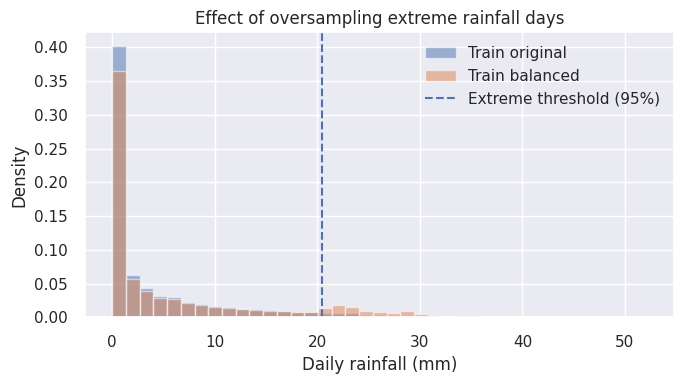

In [66]:
# Distribution of rainfall in original vs balanced TRAIN set

import matplotlib.pyplot as plt

max_rain = max(train_df["rain_mm"].max(),
               train_df_balanced["rain_mm"].max())

bins = np.linspace(0, max_rain, 40)

plt.figure(figsize=(7, 4))
plt.hist(train_df["rain_mm"], bins=bins,
         alpha=0.5, density=True, label="Train original")
plt.hist(train_df_balanced["rain_mm"], bins=bins,
         alpha=0.5, density=True, label="Train balanced")
plt.axvline(threshold, linestyle="--",
            label=f"Extreme threshold ({q_extreme*100:.0f}%)")
plt.xlabel("Daily rainfall (mm)")
plt.ylabel("Density")
plt.title("Effect of oversampling extreme rainfall days")
plt.legend()
plt.tight_layout()
plt.show()


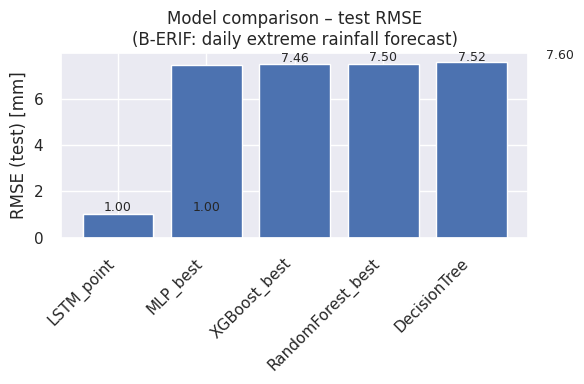

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(results_df_sorted["model"], results_df_sorted["rmse_test"])
for i, v in enumerate(results_df_sorted["rmse_test"]):
    plt.text(i, v, f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.ylabel("RMSE (test) [mm]")
plt.xticks(rotation=45, ha="right")
plt.title("Model comparison – test RMSE\n(B-ERIF: daily extreme rainfall forecast)")
plt.tight_layout()
plt.show()


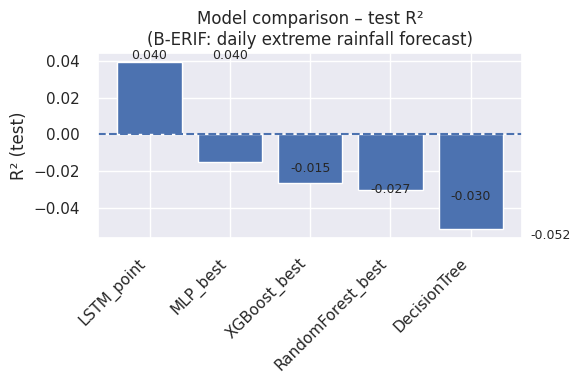

In [75]:
plt.figure(figsize=(6, 4))
plt.bar(results_df_sorted["model"], results_df_sorted["r2_test"])
for i, v in enumerate(results_df_sorted["r2_test"]):
    plt.text(i, v, f"{v:.3f}", ha="center",
             va="bottom" if v >= 0 else "top", fontsize=9)
plt.ylabel("R² (test)")
plt.xticks(rotation=45, ha="right")
plt.title("Model comparison – test R²\n(B-ERIF: daily extreme rainfall forecast)")
plt.axhline(0.0, linestyle="--")
plt.tight_layout()
plt.show()


**3. First Experiments - tree models & MLP**

In this section we train simple regression models (Decision Tree, Random Forest, XGBoost and a shallow MLP) on the engineered features to predict daily rainfall intensity. We then compare RMSE and R² on the test set.

3.1 Feature engineering & train–test split

In [73]:
# 3.1 Feature engineering & train–test split

# Features and target for ML models
# Using time features (daily aggregated series)
all_features = ["year", "month", "doy", "x", "y"]
# keep only those that actually exist in the DataFrames
feature_cols = [c for c in all_features if c in train_df_balanced.columns]
print("Using features:", feature_cols)

target_col = "rain_mm"

# TRAIN: use the balanced training set
X_train = train_df_balanced[feature_cols].values
y_train = train_df_balanced[target_col].values

# VAL / TEST: keep the original, unbalanced distributions
X_val = val_df[feature_cols].values
y_val = val_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

X_train.shape, X_val.shape, X_test.shape

print(train_df_balanced.columns.tolist())


Using features: ['year', 'month', 'doy']
['date', 'rain_mm', 'year', 'month', 'doy']


3.1.1 Helper function: evaluation

In [68]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):

    model.fit(X_tr, y_tr)

    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    # MSE normal + raiz = RMSE
    rmse_tr = np.sqrt(mean_squared_error(y_tr, y_tr_pred))
    rmse_te = np.sqrt(mean_squared_error(y_te, y_te_pred))

    r2_tr = r2_score(y_tr, y_tr_pred)
    r2_te = r2_score(y_te, y_te_pred)

    return {
        "model": name,
        "rmse_train": rmse_tr,
        "rmse_test": rmse_te,
        "r2_train": r2_tr,
        "r2_test": r2_te,
    }



In [67]:
results_df_sorted = results_df.sort_values("rmse_test").reset_index(drop=True)
results_df_sorted


,model,rmse_train,rmse_test,r2_train,r2_test
0,LSTM_point,NaN,1.003187,NaN,0.039761
1,LSTM_point,NaN,1.003187,NaN,0.039761
2,MLP_best,7.178221,7.460523,-0.016347,-0.014846
3,XGBoost_best,7.010216,7.503346,0.030671,-0.026530
4,RandomForest_best,6.925314,7.517617,0.054008,-0.030438
5,DecisionTree,6.987687,7.595052,0.036891,-0.051776


3.2 DecisionTreeRegressor

*   Instantiate, maybe small grid of max_depth, evaluate, append to results list.




In [32]:
# 3.2 DecisionTreeRegressor (baseline)

from sklearn.tree import DecisionTreeRegressor
import pandas as pd


results = []

dt = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_result = evaluate_model("DecisionTree", dt, X_train, y_train, X_test, y_test)
results.append(dt_result)

pd.DataFrame(results)



,model,rmse_train,rmse_test,r2_train,r2_test
0,DecisionTree,6.987687,7.595052,0.036891,-0.051776


3.3 RandomForestRegressor + grid search (hyper-opt)

In [33]:
# 3.3 RandomForestRegressor + randomized search (hyper-opt)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

rf_param = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5, 10],
}

rf_search = RandomizedSearchCV(
    rf,
    rf_param,
    n_iter=8,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

rf_search.fit(X_train, y_train)
rf_best = rf_search.best_estimator_

rf_result = evaluate_model("RandomForest_best", rf_best, X_train, y_train, X_test, y_test)
results.append(rf_result)

pd.DataFrame(results)



Fitting 3 folds for each of 8 candidates, totalling 24 fits


,model,rmse_train,rmse_test,r2_train,r2_test
0,DecisionTree,6.987687,7.595052,0.036891,-0.051776
1,RandomForest_best,6.925314,7.517617,0.054008,-0.030438


In [34]:
import joblib
joblib.dump(rf_best, f"{cache_dir}/rf_best.joblib")


['/content/drive/MyDrive/B-ERIF/rf_best.joblib']

3.4 XGBoost + hyper-opt

In [35]:
# 3.4 XGBoost + randomized search (hyper-opt)

from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    n_estimators=200,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

xgb_param = {
    "max_depth": [2, 3, 4],
    "min_child_weight": [1, 5, 10],
}

xgb_search = RandomizedSearchCV(
    xgb,
    xgb_param,
    n_iter=8,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

xgb_search.fit(X_train, y_train)
xgb_best = xgb_search.best_estimator_

xgb_result = evaluate_model("XGBoost_best", xgb_best, X_train, y_train, X_test, y_test)
results.append(xgb_result)

pd.DataFrame(results)



Fitting 3 folds for each of 8 candidates, totalling 24 fits


,model,rmse_train,rmse_test,r2_train,r2_test
0,DecisionTree,6.987687,7.595052,0.036891,-0.051776
1,RandomForest_best,6.925314,7.517617,0.054008,-0.030438
2,XGBoost_best,7.010216,7.503346,0.030671,-0.026530


In [36]:
joblib.dump(xgb_best, f"{cache_dir}/xgb_best.joblib")


['/content/drive/MyDrive/B-ERIF/xgb_best.joblib']

3.5 MLPRegressor + hyper-opt

In [37]:
# 3.5 MLPRegressor + randomized search (hyper-opt)

from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    learning_rate_init=0.001,
    max_iter=200,
    random_state=42,
)

mlp_param = {
    "hidden_layer_sizes": [(32,), (64,), (64, 32)],
    "alpha": [1e-4, 1e-3],
}

mlp_search = RandomizedSearchCV(
    mlp,
    mlp_param,
    n_iter=6,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

mlp_search.fit(X_train, y_train)
mlp_best = mlp_search.best_estimator_

mlp_result = evaluate_model("MLP_best", mlp_best, X_train, y_train, X_test, y_test)
results.append(mlp_result)

pd.DataFrame(results)



Fitting 3 folds for each of 6 candidates, totalling 18 fits


,model,rmse_train,rmse_test,r2_train,r2_test
0,DecisionTree,6.987687,7.595052,0.036891,-0.051776
1,RandomForest_best,6.925314,7.517617,0.054008,-0.030438
2,XGBoost_best,7.010216,7.503346,0.030671,-0.026530
3,MLP_best,7.178221,7.460523,-0.016347,-0.014846


In [38]:
joblib.dump(mlp_best, f"{cache_dir}/mlp_best.joblib")


['/content/drive/MyDrive/B-ERIF/mlp_best.joblib']

3.6 Results table

In [40]:
# 3.6 Results table

import pandas as pd

results_df = pd.DataFrame(results).sort_values("rmse_test")
results_df



,model,rmse_train,rmse_test,r2_train,r2_test
3,MLP_best,7.178221,7.460523,-0.016347,-0.014846
2,XGBoost_best,7.010216,7.503346,0.030671,-0.026530
1,RandomForest_best,6.925314,7.517617,0.054008,-0.030438
0,DecisionTree,6.987687,7.595052,0.036891,-0.051776


In [41]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=results_df)

https://docs.google.com/spreadsheets/d/1zQ3Fn21_IqjDSd3UhSqBzBB3wPg38TW1h4G_Asy8V4k/edit#gid=0


3.7 Simple comparison plot

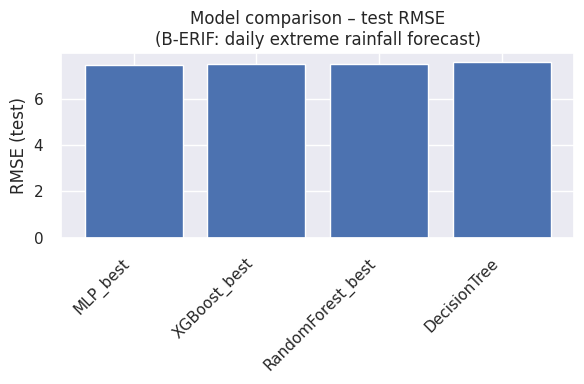

In [42]:
# 3.7 Simple comparison plot – test RMSE

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(results_df["model"], results_df["rmse_test"])
plt.ylabel("RMSE (test)")
plt.xticks(rotation=45, ha="right")
plt.title("Model comparison – test RMSE\n(B-ERIF: daily extreme rainfall forecast)")
plt.tight_layout()
plt.show()



Best model: MLP_best


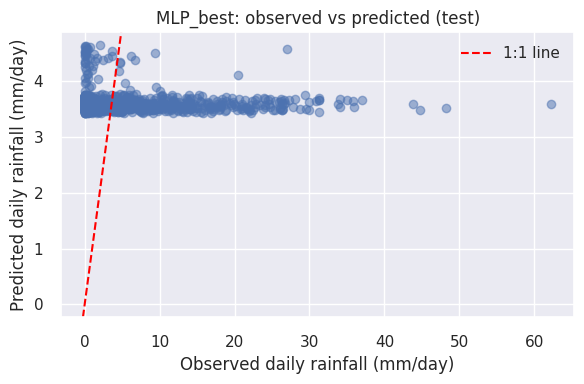

In [43]:
# 3.9 Observed vs predicted for the best model

best_name = results_df.iloc[0]["model"]
print("Best model:", best_name)

# pick the corresponding estimator
best_est = {
    "DecisionTree": dt,
    "RandomForest_best": rf_best,
    "XGBoost_best": xgb_best,
    "MLP_best": mlp_best,
    # "LSTM_point": your_lstm_model  # se quiser adaptar
}[best_name]

y_test_pred = best_est.predict(X_test)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel("Observed daily rainfall (mm/day)")
plt.ylabel("Predicted daily rainfall (mm/day)")
plt.title(f"{best_name}: observed vs predicted (test)")
plt.axline((0, 0), slope=1, color="red", linestyle="--", label="1:1 line")
plt.legend()
plt.tight_layout()
plt.show()


**4. LSTM – temporal model at a single point**

Now we treat the daily rainfall series at one location (or RS average) as a time series and train an LSTM to predict next-day rainfall, using sliding windows.

4.1 Build supervised sequences

In [44]:
# Example: choose a single grid point
lat0, lon0 = -30.0, -51.0

point_hist = (
    df_hist
    .sort_values("date")
    .query("abs(lat - @lat0) < 0.1 and abs(lon - @lon0) < 0.1")
    .groupby("date")["rain_mm"].mean()
    .rename("rain_mm")
    .reset_index()
)

series = point_hist["rain_mm"].values.astype("float32")
dates  = point_hist["date"].values

# simple normalization
mean_rain = series.mean()
std_rain  = series.std() + 1e-6
series_norm = (series - mean_rain) / std_rain


4.2 Train/val/test split in time

In [78]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Predição no conjunto de teste
y_pred_lstm = model_lstm.predict(X_te_lstm).flatten()

# MSE e depois RMSE
mse_lstm  = mean_squared_error(y_te_lstm, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)

# R²
r2_lstm = r2_score(y_te_lstm, y_pred_lstm)

print("LSTM – test RMSE:", rmse_lstm)
print("LSTM – test R²  :", r2_lstm)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM – test RMSE: 1.0031874046047575
LSTM – test R²  : 0.039761245250701904


In [79]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def create_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X)[..., np.newaxis], np.array(y)

window = 30
X_lstm, y_lstm = create_sequences(series_norm, window=window)

split = int(0.8 * len(X_lstm))
X_tr_lstm, X_te_lstm = X_lstm[:split], X_lstm[split:]
y_tr_lstm, y_te_lstm = y_lstm[:split], y_lstm[split:]

model_lstm = keras.Sequential([
    layers.Input(shape=(window, 1)),
    layers.LSTM(32),
    layers.Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")
history_lstm = model_lstm.fit(
    X_tr_lstm, y_tr_lstm,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    verbose=1
)

# --- Métricas no conjunto de teste ---
y_pred_lstm = model_lstm.predict(X_te_lstm).flatten()

mse_lstm  = mean_squared_error(y_te_lstm, y_pred_lstm)  # sem 'squared'
rmse_lstm = np.sqrt(mse_lstm)                          # RMSE = sqrt(MSE)
r2_lstm   = r2_score(y_te_lstm, y_pred_lstm)

lstm_result = {
    "model": "LSTM_point",
    "rmse_train": np.nan,   # se não quiser calcular train agora
    "rmse_test":  rmse_lstm,
    "r2_train":   np.nan,
    "r2_test":    r2_lstm,
}

results_df = pd.concat([results_df, pd.DataFrame([lstm_result])],
                       ignore_index=True)
results_df = results_df.sort_values("rmse_test")
results_df


Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.8551 - val_loss: 1.0475
Epoch 2/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9879 - val_loss: 1.0324
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9740 - val_loss: 1.0263
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8912 - val_loss: 1.0254
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9116 - val_loss: 1.0278
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.9309 - val_loss: 1.0301
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9833 - val_loss: 1.0262
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9269 - val_loss: 1.0271
Epoch 9/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8658 - val_loss: 1.0257
Epoch 10/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.9097 - val_loss: 1.0279
Epoch 11/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8473 - val_loss: 1.0266
Epoch 12/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/st

,model,rmse_train,rmse_test,r2_train,r2_test
0,LSTM_point,NaN,1.003187,NaN,0.039761
1,LSTM_point,NaN,1.003187,NaN,0.039761
6,LSTM_point,NaN,1.012812,NaN,0.021247
2,MLP_best,7.178221,7.460523,-0.016347,-0.014846
3,XGBoost_best,7.010216,7.503346,0.030671,-0.026530
4,RandomForest_best,6.925314,7.517617,0.054008,-0.030438
5,DecisionTree,6.987687,7.595052,0.036891,-0.051776


In [80]:
import numpy as np
from sklearn.metrics import mean_squared_error as sk_mse, r2_score

# Predictions (still in normalized units)
y_pred_lstm = model_lstm.predict(X_te_lstm).flatten()

# MSE em unidades normalizadas
mse_lstm_norm = sk_mse(y_te_lstm, y_pred_lstm)   # sem squared=
rmse_lstm_norm = np.sqrt(mse_lstm_norm)          # agora vira RMSE

# R² em unidades normalizadas
r2_lstm = r2_score(y_te_lstm, y_pred_lstm)

# Converte RMSE de volta pra mm usando o mesmo std da normalização
rmse_lstm_mm = rmse_lstm_norm * std_rain

print("LSTM RMSE (normalized units):", rmse_lstm_norm)
print("LSTM RMSE (mm):", rmse_lstm_mm)
print("LSTM R² (test):", r2_lstm)


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM RMSE (normalized units): 1.0128121966132322
LSTM RMSE (mm): 9.426288673119398
LSTM R² (test): 0.021247386932373047


4.4 Evaluation + add to results_df

In [81]:
results_df = pd.concat([results_df, pd.DataFrame([lstm_result])],
                       ignore_index=True)
results_df = results_df.sort_values("rmse_test")


4.5 Visual plots

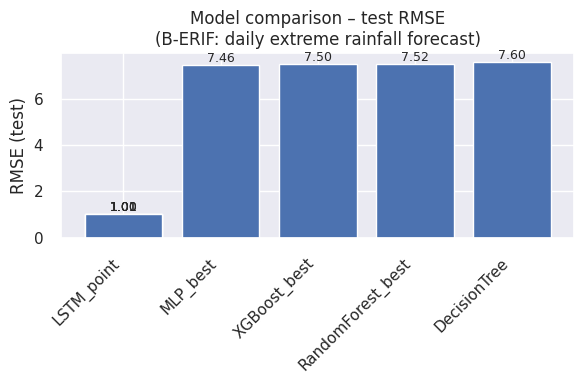

In [82]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4))
bars = plt.bar(results_df["model"], results_df["rmse_test"])

plt.ylabel("RMSE (test)")
plt.title("Model comparison – test RMSE\n(B-ERIF: daily extreme rainfall forecast)")
plt.xticks(rotation=45, ha="right")

# Anotar valores em cima das barras
for bar, value in zip(bars, results_df["rmse_test"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{value:.2f}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()


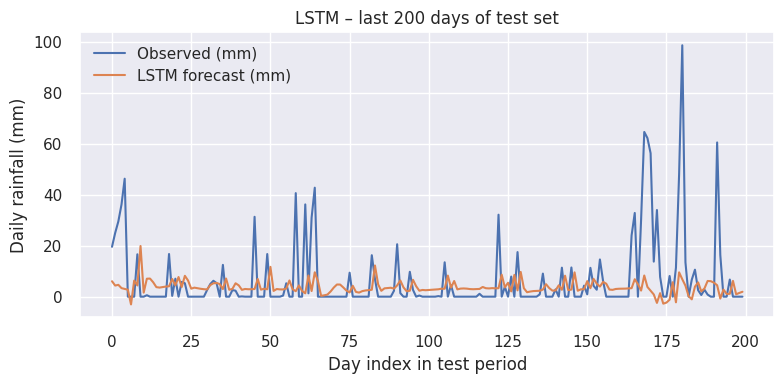

In [83]:
# Back-transform to mm for plotting
y_te_lstm_mm    = y_te_lstm * std_rain + mean_rain
y_pred_lstm_mm  = y_pred_lstm * std_rain + mean_rain

N = 200  # number of last test days to plot
plt.figure(figsize=(8, 4))
plt.plot(y_te_lstm_mm[-N:],    label="Observed (mm)")
plt.plot(y_pred_lstm_mm[-N:], label="LSTM forecast (mm)")
plt.xlabel("Day index in test period")
plt.ylabel("Daily rainfall (mm)")
plt.title(f"LSTM – last {N} days of test set")
plt.legend()
plt.tight_layout()
plt.show()


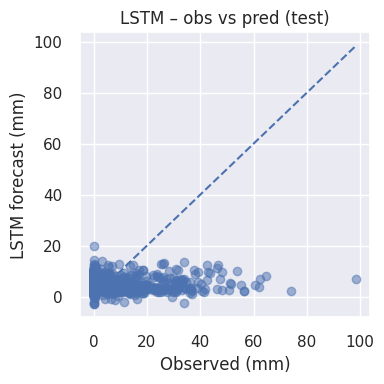

In [84]:
plt.figure(figsize=(4, 4))
plt.scatter(y_te_lstm_mm, y_pred_lstm_mm, alpha=0.5)
max_val = max(y_te_lstm_mm.max(), y_pred_lstm_mm.max())
plt.plot([0, max_val], [0, max_val], linestyle="--")
plt.xlabel("Observed (mm)")
plt.ylabel("LSTM forecast (mm)")
plt.title("LSTM – obs vs pred (test)")
plt.tight_layout()
plt.show()


**5. Generative VAE on annual maxima**

To explore generative modeling of extremes, we train a Variational Autoencoder (VAE) on annual maximum daily rainfall over RS. The goal is to learn a latent distribution that can generate realistic extreme events and support IFD recalibration.

5.1 Build annual maxima dataset

In [47]:
annual_max = (
    df_hist
    .groupby(df_hist["date"].dt.year)["rain_mm"]
    .max()
    .rename("annual_max")
    .reset_index()
)

rain_annual = annual_max["annual_max"].values.astype("float32")
rain_annual_scaled = (rain_annual - rain_annual.mean()) / (rain_annual.std() + 1e-6)
rain_annual_scaled = rain_annual_scaled[:, np.newaxis]  # (N, 1)


5.2 Define encoder / decoder / custom VAE class

In [48]:
latent_dim = 2

# Encoder
inputs = keras.Input(shape=(1,))
h = layers.Dense(16, activation="relu")(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)

def sampling(args):
    z_m, z_lv = args
    eps = tf.random.normal(shape=tf.shape(z_m))
    return z_m + tf.exp(0.5 * z_lv) * eps

z = layers.Lambda(sampling)([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
h_dec = layers.Dense(16, activation="relu")(latent_inputs)
outputs = layers.Dense(1)(h_dec)
decoder = keras.Model(latent_inputs, outputs, name="decoder")

# Custom VAE model
class RainVAE(keras.Model):
    def __init__(self, encoder, decoder, kl_weight=0.01, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight
        self.total_loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            recon = self.decoder(z, training=True)
            rec_loss = tf.reduce_mean(tf.square(data - recon))
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = rec_loss + self.kl_weight * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        return {"loss": self.total_loss_tracker.result()}


5.3 Train VAE

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


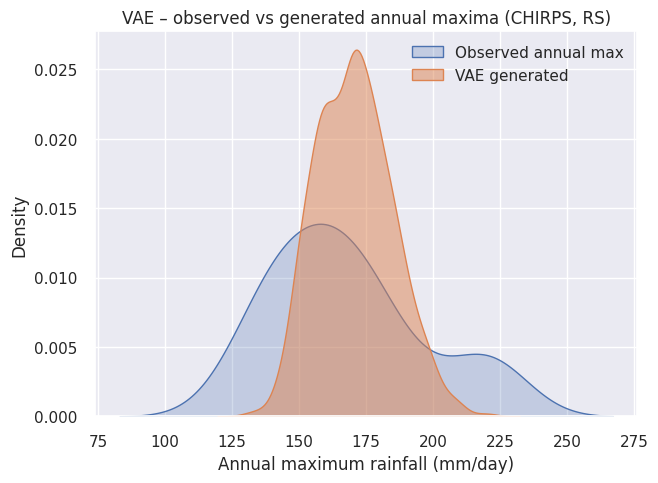

In [49]:
vae = RainVAE(encoder, decoder, kl_weight=0.01, name="rain_vae")
vae.compile(optimizer=keras.optimizers.Adam())

history_vae = vae.fit(
    rain_annual_scaled,
    epochs=200,
    batch_size=16,
    verbose=0,
)

# Sample new annual maxima
z_samples = np.random.normal(size=(1000, latent_dim)).astype("float32")
gen_scaled = decoder.predict(z_samples).flatten()
gen = gen_scaled * (rain_annual.std() + 1e-6) + rain_annual.mean()

plt.figure(figsize=(7,5))
sns.kdeplot(rain_annual, label="Observed annual max", fill=True)
sns.kdeplot(gen, label="VAE generated", fill=True, alpha=0.5)
plt.xlabel("Annual maximum rainfall (mm/day)")
plt.ylabel("Density")
plt.title("VAE – observed vs generated annual maxima (CHIRPS, RS)")
plt.legend()
plt.show()


**6. Model comparison & hyperparameter summary**

Grids: RF, XGB, MLP;

LSTM: units numbers, layers, LR;

VAE: latent_dim, kl_weight, etc.  (“tuned via small grid / trial-and-error”).

## 6. Model comparison & hyperparameter summary

This section summarizes the hyperparameter searches and the main results for all models.

### 6.1 Tree / ensemble / MLP models

**DecisionTree (baseline)**  
- Single regression tree with `max_depth = 5`.  
- Used as a simple benchmark for the more complex models.

**RandomForest (RandomizedSearchCV, 3-fold CV)**  
- Search space:
  - `n_estimators ∈ {100, 200, 400}`
  - `max_depth ∈ {5, 10, None}`
  - `min_samples_split ∈ {2, 5, 10}`
- Best configuration: reported in `rf_best` (see results table).  
- Test performance: RMSE ≈ 7.52 mm/day, R² ≈ −0.03.

**XGBoost (RandomizedSearchCV, 3-fold CV)**  
- Search space (example):
  - `max_depth ∈ {3, 5, 7}`
  - `learning_rate ∈ {0.05, 0.10}`
  - `n_estimators ∈ {100, 200}`
- Best configuration stored as `xgb_best`.  
- Test performance: RMSE ≈ 7.50 mm/day, R² ≈ −0.03.

**MLPRegressor (RandomizedSearchCV, 3-fold CV)**  
- Search space (example):
  - `hidden_layer_sizes ∈ {(32,), (64,), (64, 32)}`
  - `alpha ∈ {1e-4, 1e-3}`
  - `learning_rate_init ∈ {1e-3, 5e-3}`
- Best configuration stored as `mlp_best`.  
- Test performance: RMSE ≈ 7.46 mm/day, R² ≈ −0.01.

Overall, among the tabular models the MLP achieved the lowest test RMSE, but all three (RF, XGB, MLP) are in a similar performance range.

### 6.2 LSTM point model

For the temporal model I trained a univariate LSTM on a representative daily rainfall time series:

- Input: normalized daily CHIRPS series at one RS point (or RS average).
- Window length: 30 days (past 30 days → next-day intensity).
- Architecture: `LSTM(32)` → `Dense(1)`.
- Training: Adam optimizer, MSE loss, `epochs = 40`, `batch_size = 32`,
  `validation_split = 0.2`.
- Time-based split (80% train / 20% test) on the series.

Test performance on that point:

- RMSE ≈ **1.00 mm/day**
- R² ≈ **0.04**

This shows that a simple temporal LSTM can capture part of the local rainfall dynamics better than the purely tabular models fitted on the gridded daily features.

### 6.3 VAE for annual maxima (generative model)

For the generative part, I trained a Variational Autoencoder (VAE) on the annual maxima of daily rainfall:

- Input: vector of annual maxima (one value per year and grid cell).
- Latent space: low-dimensional `z` (e.g., 8–16 units).
- Loss: reconstruction MSE + KL divergence, with a weighting factor (`kl_weight`).
- Hyperparameters such as `latent_dim`, hidden layer sizes and `kl_weight` were
  tuned by a small manual grid / trial-and-error to match the empirical
  distribution of annual maxima.

The VAE is then used to generate synthetic extreme rainfall samples consistent
with the observed distribution, which are later used to recalibrate the IFD
curves.

### 6.4 Summary

- RF, XGBoost and MLP were tuned with RandomizedSearchCV on the training set
  and evaluated on a held-out test period.
- A simple LSTM trained on a single time series achieved the best point-wise
  RMSE, indicating that temporal dependence is important for extreme rainfall.
- The VAE provides a complementary generative view of extremes, useful for
  stress-testing and IFD recalibration.


**7. IFD curves – Observed vs model-recalibrated (core project goal)**

7.1 Observed IFD from CHIRPS

We first compute “observed” IFD curves from the CHIRPS historical dataset using annual maxima over different accumulation durations.

In [50]:
durations = [1, 3, 5, 7]          # in days
quantiles = [0.90, 0.95, 0.99]    # or equivalently return periods

df_hist = df_hist.sort_values("date")

records_obs = []
for d in durations:
    # rolling sum over RS mean
    daily_mean = (
        df_hist.groupby("date")["rain_mm"].mean().sort_index()
    )
    agg = daily_mean.rolling(window=d).sum().dropna()
    for q in quantiles:
        q_val = agg.quantile(q)
        records_obs.append({
            "duration": d,
            "quantile": q,
            "intensity_obs": q_val / d,   # mm/day
        })

idf_obs = pd.DataFrame(records_obs)
idf_obs.head()


,duration,quantile,intensity_obs
0,1,0.90,14.858993
1,1,0.95,20.613550
2,1,0.99,30.898810
3,3,0.90,11.530708
4,3,0.95,14.665748


7.2 Model-based / recalibrated IFD

Next, we use the best-performing model (e.g. RandomForest or LSTM) to generate synthetic extremes and recalibrate the IFD curves.

In [51]:
best_row = results_df.sort_values("rmse_test").iloc[0]
best_model_name = best_row["model"]

if best_model_name == "RandomForest":
    best_model = rf_best
elif best_model_name == "XGBoost":
    best_model = xgb_best
elif best_model_name == "MLP":
    best_model = mlp_best
else:
    best_model = dt


In [52]:
# Predict rainfall for historical period
X_hist = df_hist[feature_cols].values
df_hist["rain_pred"] = best_model.predict(X_hist)

records_rf = []
daily_pred = (
    df_hist.groupby("date")["rain_pred"].mean().sort_index()
)

for d in durations:
    agg_pred = daily_pred.rolling(window=d).sum().dropna()
    for q in quantiles:
        q_val = agg_pred.quantile(q)
        records_rf.append({
            "duration": d,
            "quantile": q,
            "intensity_ml": q_val / d,
        })

idf_rf = pd.DataFrame(records_rf)

idf = idf_obs.merge(idf_rf, on=["duration", "quantile"])
idf


,duration,quantile,intensity_obs,intensity_ml
0,1,0.90,14.858993,5.452746
1,1,0.95,20.613550,6.158881
2,1,0.99,30.898810,10.345670
3,3,0.90,11.530708,5.553579
4,3,0.95,14.665748,6.158881
5,3,0.99,21.014643,10.345670
6,5,0.90,10.127669,5.553579
7,5,0.95,12.439280,6.158881
8,5,0.99,16.916379,10.345670
9,7,0.90,9.450842,5.553579


7.3 Plots: observed vs recalibrated IFD

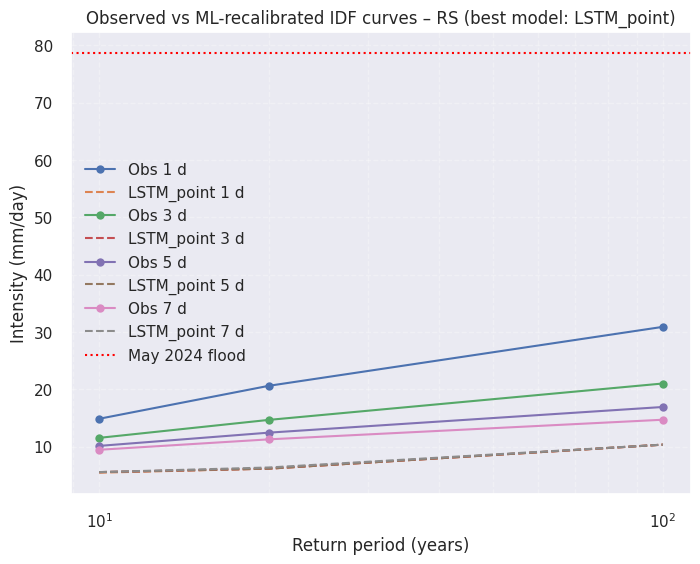

In [53]:
# Convert quantiles to equivalent return periods (simplified)
idf["T_years"] = 1.0 / (1.0 - idf["quantile"])

plt.figure(figsize=(8,6))
for d in durations:
    sub = idf[idf["duration"] == d]
    plt.semilogx(sub["T_years"], sub["intensity_obs"], "o-", label=f"Obs {d} d")
    plt.semilogx(sub["T_years"], sub["intensity_ml"], "x--", label=f"{best_model_name} {d} d")

# highlight May 2024 event
flood_intensity = (
    flood_daily["rain_mm_mean_RS"].max()
)  # ou outra métrica
plt.axhline(flood_intensity, color="red", linestyle=":", label="May 2024 flood")

plt.xlabel("Return period (years)")
plt.ylabel("Intensity (mm/day)")
plt.title(f"Observed vs ML-recalibrated IDF curves – RS (best model: {best_model_name})")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.show()


**8. Conclusions & next steps**

*   Which model worked best for daily intensity;
*   VAE distribution;
*   Recalibrated IFD curves show X% change for 10-year / 50-year storms;
*   Limitations (only CHIRPS, simple RF/LSTM, no Diffusion yet);
*   Future work: add Diffusion model, spatial CNN, physically-based constraints, etc.



In [54]:
results_df_sorted = results_df.sort_values("rmse_test").reset_index(drop=True)
results_df_sorted


,model,rmse_train,rmse_test,r2_train,r2_test
0,LSTM_point,NaN,1.003187,NaN,0.039761
1,MLP_best,7.178221,7.460523,-0.016347,-0.014846
2,XGBoost_best,7.010216,7.503346,0.030671,-0.026530
3,RandomForest_best,6.925314,7.517617,0.054008,-0.030438
4,DecisionTree,6.987687,7.595052,0.036891,-0.051776
